#  Combined All-Well Analysis

### This notebook performs a comprehensive analysis across all wells to identify consistent patterns and correlations between log and lab measurements.


#  Import Libraries and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
import missingno as msno

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for plots
Path('imgs').mkdir(exist_ok=True)

# Define well colors for consistent visualization
well_colors = {
    'HRDH_1119': '#1f77b4',
    'HRDH_1804': '#ff7f0e',
    'HRDH_1867': '#2ca02c',
    'HRDH_697': '#d62728',
    # Add more wells as needed
}


#  Data Loading and Preparation


In [2]:
def load_all_wells(base_path="."):
    """Load all joined CSV files and combine them into a single DataFrame"""
    
    # Find all joined CSV files
    csv_files = list(Path(base_path).glob('HRDH_*/HRDH_*_joined.csv'))
    
    print(f"Found {len(csv_files)} joined CSV files:")
    for file in csv_files:
        print(f"  - {file}")
    
    # Load each file and add well identifier
    all_wells = []
    
    for csv_file in csv_files:
        # Extract well name from folder name
        well_name = csv_file.parent.name
        
        # Load data
        df = pd.read_csv(csv_file)
        
        # Add well identifier
        df['Well'] = well_name
        
        # Add to list
        all_wells.append(df)
        
        print(f"\nLoaded {well_name}: {df.shape[0]} samples, {df.shape[1]} columns")
    
    # Concatenate all dataframes
    df_all = pd.concat(all_wells, ignore_index=True)
    
    print(f"\n✅ Combined dataset: {df_all.shape[0]} total samples from {df_all['Well'].nunique()} wells")
    print(f"Wells: {', '.join(df_all['Well'].unique())}")
    
    return df_all

# Load all data
df_all = load_all_wells()

Found 4 joined CSV files:
  - HRDH_1119\HRDH_1119_joined.csv
  - HRDH_1804\HRDH_1804_joined.csv
  - HRDH_1867\HRDH_1867_joined.csv
  - HRDH_697\HRDH_697_joined.csv

Loaded HRDH_1119: 18 samples, 73 columns

Loaded HRDH_1804: 41 samples, 56 columns

Loaded HRDH_1867: 9 samples, 59 columns

Loaded HRDH_697: 10 samples, 66 columns

✅ Combined dataset: 78 total samples from 4 wells
Wells: HRDH_1119, HRDH_1804, HRDH_1867, HRDH_697


#  Data Overview and Column Classification


In [3]:

# Classify columns
# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']

# Convert to Log_ prefixed names
specific_log_columns = [f'Log_{log}' for log in specific_logs]

# Filter columns
lab_columns = [col for col in df_all.columns if col.startswith('Lab_') and col != 'Lab_Depth' and col != 'Lab_Sample_ID']

# Only include log columns that are in the specific list
all_log_columns = [col for col in df_all.columns if col.startswith('Log_') and col != 'Log_Depth' and col != 'Log_FRAMENO']
log_columns = [col for col in all_log_columns if col in specific_log_columns]

# Check which specific logs are missing
available_logs = [col.replace('Log_', '') for col in log_columns]
missing_logs = [log for log in specific_logs if log not in available_logs]

metadata_columns = ['Lab_Depth', 'Log_Depth', 'Distance', 'Match_Type', 'Well']

# Remove Sample_ID and FRAMENO columns if they exist
columns_to_exclude = ['Lab_Sample_ID', 'Log_FRAMENO', 'Sample_ID', 'FRAMENO']
for col in columns_to_exclude:
    if col in df_all.columns:
        print(f"Excluding column: {col}")
        df_all = df_all.drop(columns=[col])

print(f"Column Classification:")
print(f"  - Lab measurements: {len(lab_columns)}")
print(f"  - Log measurements (filtered): {len(log_columns)} out of {len(specific_logs)} requested")
print(f"  - Available logs: {', '.join(available_logs)}")
if missing_logs:
    print(f"  - Missing logs: {', '.join(missing_logs)}")
print(f"  - Metadata: {len(metadata_columns)}")
print(f"  - Total columns: {len(df_all.columns)}")

# Display sample counts per well
print("\nSamples per well:")
print(df_all['Well'].value_counts().sort_index())

# ...existing code...

Excluding column: Lab_Sample_ID
Excluding column: Log_FRAMENO
Column Classification:
  - Lab measurements: 35
  - Log measurements (filtered): 15 out of 15 requested
  - Available logs: CN, CNC, GR, GRSL, HRD1, HRD2, K, KTH, LSN, PE, QPKS, SFT2, SHR, SLTM, ZDNC
  - Metadata: 5
  - Total columns: 87

Samples per well:
Well
HRDH_1119    18
HRDH_1804    41
HRDH_1867     9
HRDH_697     10
Name: count, dtype: int64


#  Missing Data Analysis


In [4]:
# Calculate missing data percentages
missing_summary = pd.DataFrame({
    'Missing_Count': df_all.isnull().sum(),
    'Missing_Percent': (df_all.isnull().sum() / len(df_all)) * 100
}).sort_values('Missing_Percent', ascending=False)

# Display columns with significant missing data
print("Columns with >50% missing data:")
high_missing = missing_summary[missing_summary['Missing_Percent'] > 50]
print(high_missing)

Columns with >50% missing data:
                Missing_Count  Missing_Percent
Lab_XRD_Halite             69        88.461538
Log_CNL                    69        88.461538
Log_CHT.I                  68        87.179487
Log_CALZ                   60        76.923077
Log_CVOL                   51        65.384615
Log_BVOL                   51        65.384615
Log_CHT                    51        65.384615
Lab_XRF_Cl                 50        64.102564
Lab_XRF_Ca                 50        64.102564
Lab_XRF_K                  50        64.102564
Log_KTH                    50        64.102564
Lab_XRF_Ba                 50        64.102564
Lab_XRF_Fe                 50        64.102564
Lab_XRF_Zr                 50        64.102564
Lab_XRF_Sr                 50        64.102564
Lab_XRF_Mn                 50        64.102564
Lab_XRF_S                  50        64.102564
Lab_XRF_Mg                 50        64.102564
Lab_XRF_Na                 50        64.102564
Lab_XRF_P                  5

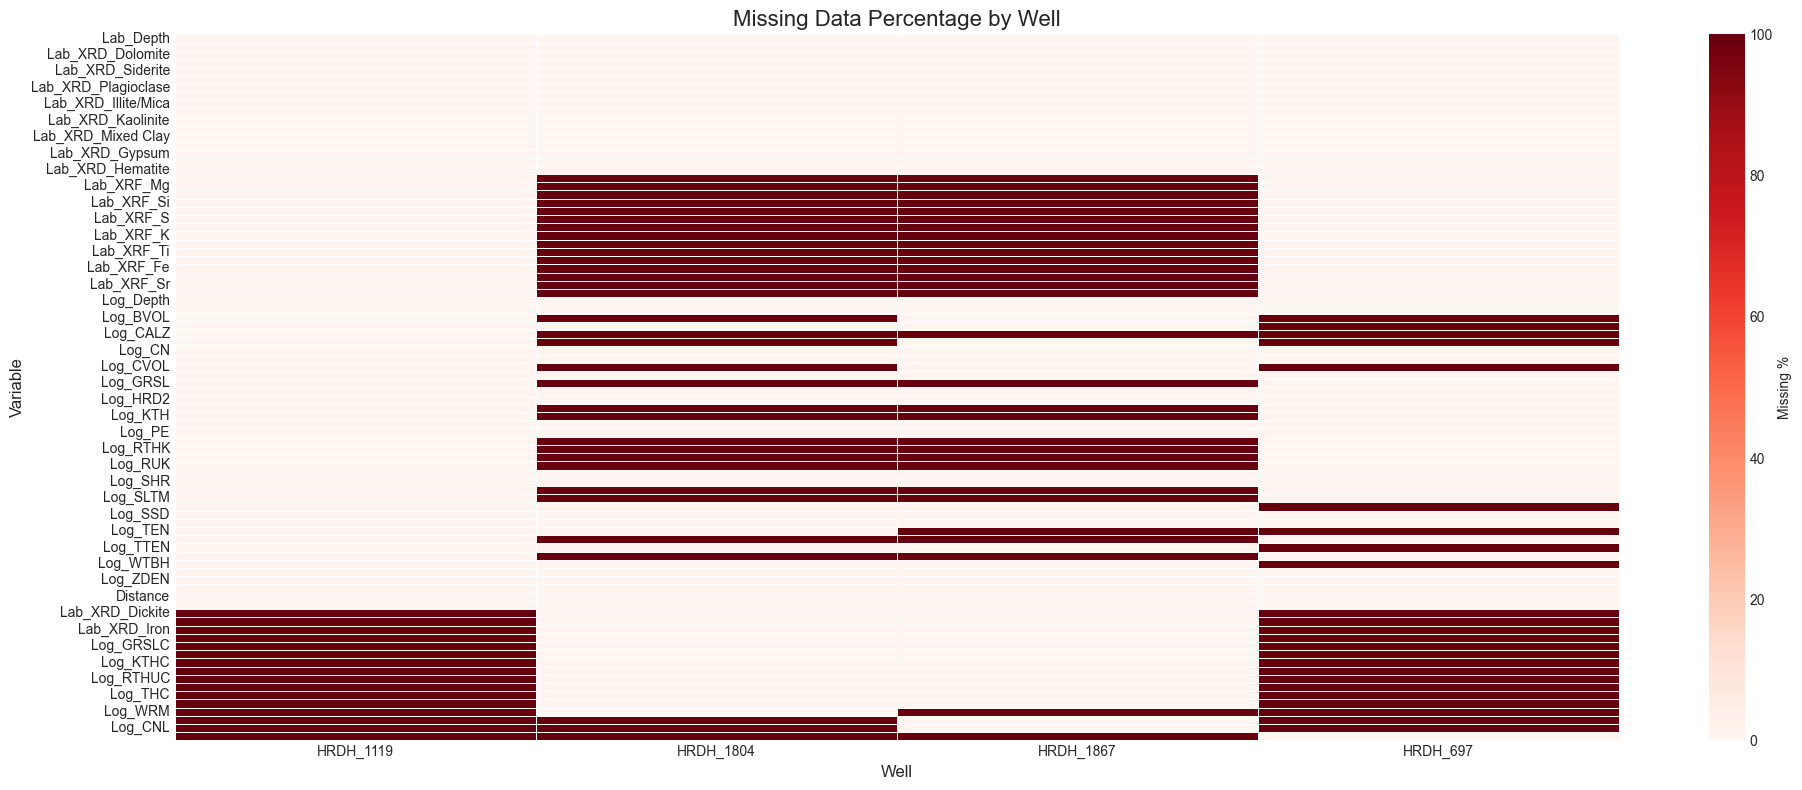

In [5]:
# Missing data heatmap by well
missing_by_well = df_all.groupby('Well').apply(lambda x: x.isnull().sum() / len(x) * 100)
missing_by_well = missing_by_well.drop('Well', axis=1)

plt.figure(figsize=(20, 8))
sns.heatmap(missing_by_well.T, cmap='Reds', cbar_kws={'label': 'Missing %'}, 
            linewidths=0.5, annot=False)
plt.title('Missing Data Percentage by Well', fontsize=16)
plt.xlabel('Well', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('imgs/missing_data_by_well_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

#  Correlation Analysis Across Wells


In [6]:
def calculate_correlations_by_well(df, lab_vars, log_vars, min_samples=10):
    """Calculate correlations for each well separately"""
    
    well_correlations = {}
    
    for well in df['Well'].unique():
        well_data = df[df['Well'] == well]
        
        # Initialize correlation matrix
        corr_matrix = pd.DataFrame(index=log_vars, columns=lab_vars, dtype=float)
        
        # Calculate correlations for each pair
        for log_var in log_vars:
            for lab_var in lab_vars:
                # Get clean data pairs
                clean_data = well_data[[log_var, lab_var]].dropna()
                
                if len(clean_data) >= min_samples:
                    corr, p_val = stats.pearsonr(clean_data[log_var], clean_data[lab_var])
                    corr_matrix.loc[log_var, lab_var] = corr
                else:
                    corr_matrix.loc[log_var, lab_var] = np.nan
        
        well_correlations[well] = corr_matrix
        
    return well_correlations

# Calculate correlations for each well
well_correlations = calculate_correlations_by_well(df_all, lab_columns, log_columns)
well_correlations

{'HRDH_1119':           Lab_XRD_Calcite  Lab_XRD_Dolomite  Lab_XRD_Ankerite  \
 Log_CN           0.066035          0.585675               NaN   
 Log_CNC          0.060789          0.589637               NaN   
 Log_GR           0.651625          0.422431               NaN   
 Log_GRSL         0.651419          0.421838               NaN   
 Log_HRD1         0.542255          0.581833               NaN   
 Log_HRD2         0.597141          0.576661               NaN   
 Log_K            0.337700          0.347373               NaN   
 Log_KTH          0.566349          0.342604               NaN   
 Log_LSN         -0.247765         -0.683837               NaN   
 Log_PE           0.477848          0.631144               NaN   
 Log_QPKS              NaN               NaN               NaN   
 Log_SFT2         0.433125          0.494642               NaN   
 Log_SHR         -0.488486         -0.660559               NaN   
 Log_SLTM         0.364886          0.204126               NaN 

#  Find Common Significant Correlations


In [7]:
def find_common_correlations(well_correlations, min_correlation=0.5, min_wells=2):
    """Find variable pairs that are significantly correlated in multiple wells"""
    
    # Track correlations across wells
    correlation_tracker = {}
    
    for well, corr_matrix in well_correlations.items():
        # Find significant correlations in this well
        for log_var in corr_matrix.index:
            for lab_var in corr_matrix.columns:
                r = corr_matrix.loc[log_var, lab_var]
                
                if not pd.isna(r) and abs(r) >= min_correlation:
                    pair = (log_var, lab_var)
                    if pair not in correlation_tracker:
                        correlation_tracker[pair] = []
                    correlation_tracker[pair].append((well, r))
    
    # Filter pairs that appear in multiple wells
    common_correlations = {
        pair: data for pair, data in correlation_tracker.items() 
        if len(data) >= min_wells
    }
    
    # Sort by number of wells and average correlation strength
    sorted_pairs = sorted(
        common_correlations.items(),
        key=lambda x: (len(x[1]), np.mean([abs(r) for _, r in x[1]])),
        reverse=True
    )
    
    return sorted_pairs

# Find common correlations
common_correlations = find_common_correlations(well_correlations, min_correlation=0.5, min_wells=2)
# print(f"\nFound {len(common_correlations_lower)} variable pairs with |r| ≥ 0.3 in at least 3 wells")

print(f"Found {len(common_correlations)} variable pairs with |r| ≥ 0.5 in at least 2 wells\n")
print("Top 10 most consistent correlations:")
print("-" * 80)

for i, (pair, wells_data) in enumerate(common_correlations[:10]):
    log_var, lab_var = pair
    wells_str = ", ".join([f"{well}(r={r:.3f})" for well, r in wells_data])
    avg_r = np.mean([r for _, r in wells_data])
    print(f"{i+1}. {log_var} vs {lab_var}")
    print(f"   Average |r| = {abs(avg_r):.3f}, Found in {len(wells_data)} wells")
    print(f"   Wells: {wells_str}")
    print()

Found 15 variable pairs with |r| ≥ 0.5 in at least 2 wells

Top 10 most consistent correlations:
--------------------------------------------------------------------------------
1. Log_SHR vs Lab_XRF_Sr
   Average |r| = 0.691, Found in 2 wells
   Wells: HRDH_1119(r=0.552), HRDH_697(r=0.830)

2. Log_PE vs Lab_XRF_Sr
   Average |r| = 0.689, Found in 2 wells
   Wells: HRDH_1119(r=-0.560), HRDH_697(r=-0.818)

3. Log_LSN vs Lab_XRF_Cl
   Average |r| = 0.663, Found in 2 wells
   Wells: HRDH_1119(r=-0.555), HRDH_697(r=-0.772)

4. Log_PE vs Lab_XRF_Fe
   Average |r| = 0.145, Found in 2 wells
   Wells: HRDH_1119(r=0.507), HRDH_697(r=-0.797)

5. Log_LSN vs Lab_XRD_Quartz
   Average |r| = 0.635, Found in 2 wells
   Wells: HRDH_1804(r=0.513), HRDH_697(r=0.757)

6. Log_SFT2 vs Lab_XRF_Si
   Average |r| = 0.010, Found in 2 wells
   Wells: HRDH_1119(r=0.634), HRDH_697(r=-0.613)

7. Log_CN vs Lab_XRD_Quartz
   Average |r| = 0.617, Found in 2 wells
   Wells: HRDH_1804(r=-0.527), HRDH_697(r=-0.707)

8. 

In [8]:

# After the existing find_common_correlations call, add:

# Analyze correlation distribution across wells
print("\n" + "="*80)
print("CORRELATION DISTRIBUTION ANALYSIS")
print("="*80)

# Check different correlation thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    common_at_threshold = find_common_correlations(well_correlations, min_correlation=threshold, min_wells=2)
    
    # Count how many wells each correlation appears in
    well_counts = {}
    for _, wells_data in common_at_threshold:
        n_wells = len(wells_data)
        if n_wells not in well_counts:
            well_counts[n_wells] = 0
        well_counts[n_wells] += 1
    
    print(f"\nAt |r| ≥ {threshold}:")
    for n_wells in sorted(well_counts.keys()):
        print(f"  {n_wells} wells: {well_counts[n_wells]} correlation pairs")

# Find correlations present in 3+ wells with lower threshold
print("\n" + "="*80)
print("CORRELATIONS IN 3+ WELLS (with lower threshold)")
print("="*80)

common_correlations_3wells = find_common_correlations(well_correlations, min_correlation=0.3, min_wells=3)
print(f"\nFound {len(common_correlations_3wells)} variable pairs with |r| ≥ 0.3 in at least 3 wells")

if len(common_correlations_3wells) > 0:
    print("\nTop correlations in 3+ wells:")
    for i, (pair, wells_data) in enumerate(common_correlations_3wells[:10]):
        log_var, lab_var = pair
        wells_str = ", ".join([f"{well}(r={r:.3f})" for well, r in wells_data])
        avg_r = np.mean([r for _, r in wells_data])
        print(f"\n{i+1}. {log_var} vs {lab_var}")
        print(f"   Average |r| = {abs(avg_r):.3f}, Found in {len(wells_data)} wells")
        print(f"   Wells: {wells_str}")

# Find correlations present in ALL 4 wells
print("\n" + "="*80)
print("CORRELATIONS IN ALL 4 WELLS")
print("="*80)

common_correlations_all = find_common_correlations(well_correlations, min_correlation=0.2, min_wells=4)
print(f"\nFound {len(common_correlations_all)} variable pairs with |r| ≥ 0.2 in all 4 wells")

if len(common_correlations_all) > 0:
    print("\nCorrelations present in all wells:")
    for i, (pair, wells_data) in enumerate(common_correlations_all[:10]):
        log_var, lab_var = pair
        wells_str = ", ".join([f"{well}(r={r:.3f})" for well, r in wells_data])
        avg_r = np.mean([r for _, r in wells_data])
        print(f"\n{i+1}. {log_var} vs {lab_var}")
        print(f"   Average |r| = {abs(avg_r):.3f}")
        print(f"   Wells: {wells_str}")




CORRELATION DISTRIBUTION ANALYSIS

At |r| ≥ 0.3:
  2 wells: 75 correlation pairs
  3 wells: 4 correlation pairs

At |r| ≥ 0.4:
  2 wells: 47 correlation pairs
  3 wells: 1 correlation pairs

At |r| ≥ 0.5:
  2 wells: 15 correlation pairs

At |r| ≥ 0.6:
  2 wells: 1 correlation pairs

At |r| ≥ 0.7:

CORRELATIONS IN 3+ WELLS (with lower threshold)

Found 4 variable pairs with |r| ≥ 0.3 in at least 3 wells

Top correlations in 3+ wells:

1. Log_LSN vs Lab_XRD_Quartz
   Average |r| = 0.294, Found in 3 wells
   Wells: HRDH_1119(r=-0.390), HRDH_1804(r=0.513), HRDH_697(r=0.757)

2. Log_SFT2 vs Lab_XRD_Quartz
   Average |r| = 0.068, Found in 3 wells
   Wells: HRDH_1119(r=0.608), HRDH_1804(r=-0.440), HRDH_697(r=-0.373)

3. Log_HRD1 vs Lab_XRD_Quartz
   Average |r| = 0.127, Found in 3 wells
   Wells: HRDH_1119(r=0.517), HRDH_1804(r=-0.441), HRDH_697(r=-0.457)

4. Log_HRD2 vs Lab_XRD_Quartz
   Average |r| = 0.085, Found in 3 wells
   Wells: HRDH_1119(r=0.505), HRDH_1804(r=-0.433), HRDH_697(r=-0.3

# Visualize Common Correlations - Combined Scatter Plots


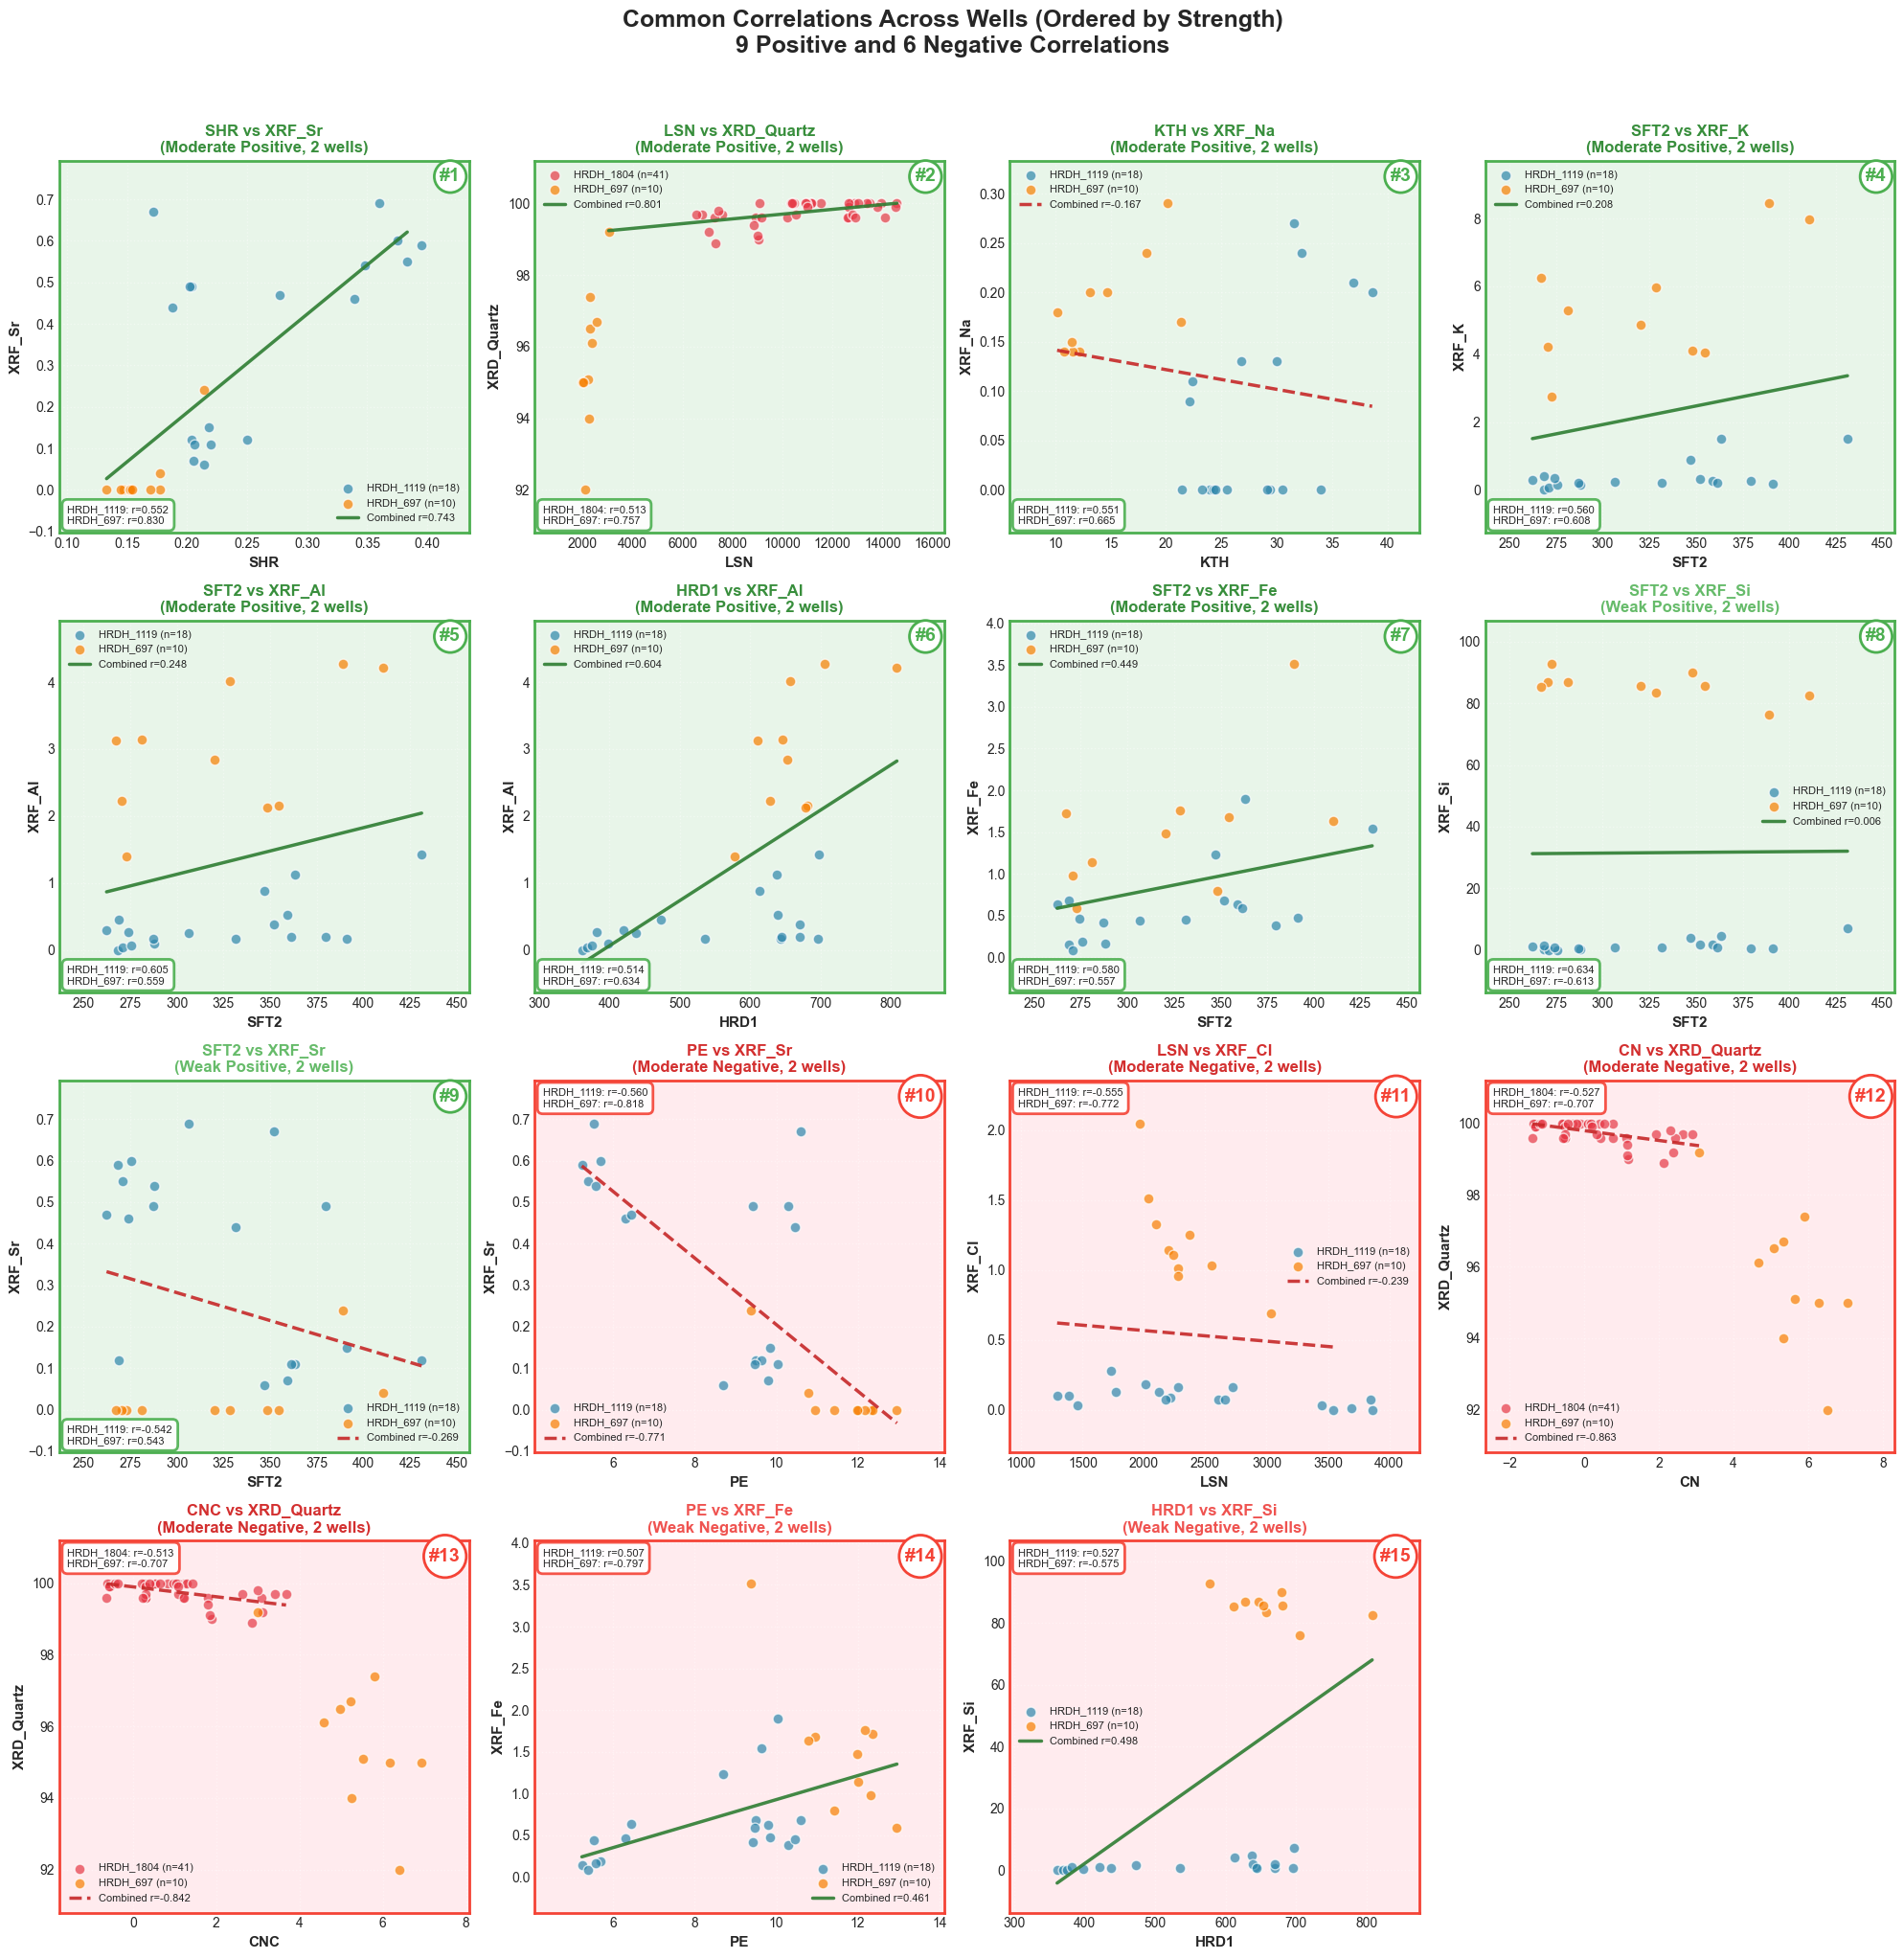


CORRELATION SUMMARY (Ordered by Strength):
Positive correlations: 9
Negative correlations: 6

Top 5 strongest correlations:
1. SHR vs XRF_Sr: avg r = 0.691 (2 wells)
2. LSN vs XRD_Quartz: avg r = 0.635 (2 wells)
3. KTH vs XRF_Na: avg r = 0.608 (2 wells)
4. SFT2 vs XRF_K: avg r = 0.584 (2 wells)
5. SFT2 vs XRF_Al: avg r = 0.582 (2 wells)


In [9]:
import os



def create_combined_scatter_plots(df, common_correlations, n_plots=12):
    """Create subplot grid showing scatter plots for common correlations"""
    
    # Sort correlations by absolute average correlation value
    sorted_correlations = sorted(
        common_correlations[:n_plots],
        key=lambda x: abs(np.mean([r for _, r in x[1]])),
        reverse=True
    )
    
    # Separate positive and negative correlations
    positive_correlations = [(pair, wells) for pair, wells in sorted_correlations 
                           if np.mean([r for _, r in wells]) > 0]
    negative_correlations = [(pair, wells) for pair, wells in sorted_correlations 
                           if np.mean([r for _, r in wells]) < 0]
    
    # Combine back: positive first, then negative
    pairs_to_plot = positive_correlations + negative_correlations
    
    # Calculate grid dimensions
    n_cols = 4
    n_rows = (len(pairs_to_plot) + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
    
    # Enhanced color palette for wells
    well_colors_enhanced = {
        'HRDH_1119': '#2E86AB',  # Deep blue
        'HRDH_1804': '#E63946',  # Vibrant red
        'HRDH_1867': '#06D6A0',  # Turquoise
        'HRDH_697': '#F77F00',   # Orange
    }
    
    # Plot each correlation
    for idx, (pair, wells_data) in enumerate(pairs_to_plot):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        log_var, lab_var = pair
        
        # Calculate average correlation for color coding
        avg_corr = np.mean([r for _, r in wells_data])
        
        # Set background color based on correlation type
        if avg_corr > 0:
            ax.set_facecolor('#E8F5E9')  # Light green for positive
            edge_color = '#4CAF50'  # Green edge
        else:
            ax.set_facecolor('#FFEBEE')  # Light red for negative
            edge_color = '#F44336'  # Red edge
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(edge_color)
            spine.set_linewidth(2)
        
        # Get list of wells that have this correlation
        wells_with_correlation = [well for well, _ in wells_data]
        
        # Collect all data first to determine axis limits
        all_x_data = []
        all_y_data = []
        
        # Plot data from each well that has this correlation
        plotted_wells = []
        for well in wells_with_correlation:
            well_data = df[df['Well'] == well]
            
            # Get clean data for this pair
            plot_data = well_data[[log_var, lab_var]].dropna()
            
            if len(plot_data) > 0:
                x_data = plot_data[log_var].values
                y_data = plot_data[lab_var].values
                
                # Collect data for axis limits
                all_x_data.extend(x_data)
                all_y_data.extend(y_data)
                
                ax.scatter(x_data, y_data, 
                          label=f'{well} (n={len(plot_data)})', 
                          alpha=0.7, s=60,
                          color=well_colors_enhanced.get(well, 'gray'),
                          edgecolors='white', linewidth=1)
                plotted_wells.append(well)
        
        # Calculate and plot overall regression line for wells with correlation
        wells_data_df = df[df['Well'].isin(wells_with_correlation)]
        all_data = wells_data_df[[log_var, lab_var]].dropna()
        
        if len(all_data) > 10:
            # Calculate overall correlation
            overall_r, overall_p = stats.pearsonr(all_data[log_var], all_data[lab_var])
            
            # Add regression line
            x = all_data[log_var].values
            y = all_data[lab_var].values
            
            # Remove outliers for regression line
            q1_x, q3_x = np.percentile(x, [25, 75])
            q1_y, q3_y = np.percentile(y, [25, 75])
            iqr_x = q3_x - q1_x
            iqr_y = q3_y - q1_y
            
            mask = ((x >= q1_x - 1.5*iqr_x) & (x <= q3_x + 1.5*iqr_x) & 
                    (y >= q1_y - 1.5*iqr_y) & (y <= q3_y + 1.5*iqr_y))
            
            x_clean = x[mask]
            y_clean = y[mask]
            
            if len(x_clean) > 10:
                z = np.polyfit(x_clean, y_clean, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                
                # Use different line styles for positive/negative correlations
                if overall_r > 0:
                    line_color = '#2E7D32'  # Dark green
                    line_style = '-'
                else:
                    line_color = '#C62828'  # Dark red
                    line_style = '--'
                
                ax.plot(x_line, p(x_line), color=line_color, linestyle=line_style, 
                       linewidth=2.5, alpha=0.9,
                       label=f'Combined r={overall_r:.3f}')
        
        # Set axis limits with better padding
        if len(all_x_data) > 0 and len(all_y_data) > 0:
            x_min, x_max = np.min(all_x_data), np.max(all_x_data)
            y_min, y_max = np.min(all_y_data), np.max(all_y_data)
            
            x_range = x_max - x_min
            y_range = y_max - y_min
            
            x_padding = 0.15 * x_range if x_range > 0 else 0.15 * abs(x_max) if x_max != 0 else 1
            y_padding = 0.15 * y_range if y_range > 0 else 0.15 * abs(y_max) if y_max != 0 else 1
            
            ax.set_xlim(x_min - x_padding, x_max + x_padding)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)
            
            ax.margins(0.05)
        
        # Customize plot
        ax.set_xlabel(log_var.replace('Log_', ''), fontsize=11, fontweight='bold')
        ax.set_ylabel(lab_var.replace('Lab_', ''), fontsize=11, fontweight='bold')
        
        # Add title with correlation strength indicator
        title = f'{log_var.replace("Log_", "")} vs {lab_var.replace("Lab_", "")}\n'
        if abs(avg_corr) >= 0.7:
            strength = "Strong"
            title_color = '#1B5E20' if avg_corr > 0 else '#B71C1C'
        elif abs(avg_corr) >= 0.5:
            strength = "Moderate"
            title_color = '#388E3C' if avg_corr > 0 else '#D32F2F'
        else:
            strength = "Weak"
            title_color = '#66BB6A' if avg_corr > 0 else '#EF5350'
        
        title += f'({strength} {"Positive" if avg_corr > 0 else "Negative"}, {len(plotted_wells)} wells)'
        ax.set_title(title, fontsize=12, fontweight='bold', color=title_color)
        
        # Enhanced grid
        ax.grid(True, alpha=0.4, linestyle=':', linewidth=1)
        
        # Legend with better positioning
        ax.legend(loc='best', fontsize=8, framealpha=0.95, 
                 edgecolor=edge_color, fancybox=True, shadow=True)
        
        # Add correlation values in a styled box
        corr_text = '\n'.join([f'{well}: r={r:.3f}' for well, r in wells_data])
        
        # Position text based on correlation type
        if avg_corr > 0:
            x_pos, y_pos = 0.02, 0.02  # Bottom left for positive
            va = 'bottom'
        else:
            x_pos, y_pos = 0.02, 0.98  # Top left for negative
            va = 'top'
        
        text_box = ax.text(x_pos, y_pos, corr_text, transform=ax.transAxes, 
                          fontsize=8, verticalalignment=va, horizontalalignment='left',
                          bbox=dict(boxstyle='round,pad=0.5', 
                                   facecolor='white', 
                                   edgecolor=edge_color,
                                   alpha=0.9,
                                   linewidth=2))
        
        # Add ranking number
        rank_text = f"#{idx + 1}"
        ax.text(0.98, 0.98, rank_text, transform=ax.transAxes,
               fontsize=14, fontweight='bold', 
               verticalalignment='top', horizontalalignment='right',
               color=edge_color,
               bbox=dict(boxstyle='circle,pad=0.3', 
                        facecolor='white', 
                        edgecolor=edge_color,
                        linewidth=2))
    
    # Hide unused subplots
    for idx in range(len(pairs_to_plot), len(axes)):
        axes[idx].set_visible(False)
    
    # Add informative title
    n_positive = len(positive_correlations)
    n_negative = len(negative_correlations)
    
    plt.suptitle(f'Common Correlations Across Wells (Ordered by Strength)\n' + 
                f'{n_positive} Positive and {n_negative} Negative Correlations', 
                fontsize=18, y=1.02, fontweight='bold')
    
    plt.tight_layout()
    os.makedirs('imgs', exist_ok=True)
    plt.savefig('imgs/common_correlations_scatter_plots_ordered.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nCORRELATION SUMMARY (Ordered by Strength):")
    print("=" * 80)
    print(f"Positive correlations: {n_positive}")
    print(f"Negative correlations: {n_negative}")
    print("\nTop 5 strongest correlations:")
    for i, (pair, wells_data) in enumerate(pairs_to_plot[:5]):
        log_var, lab_var = pair
        avg_r = np.mean([r for _, r in wells_data])
        print(f"{i+1}. {log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}: " +
              f"avg r = {avg_r:.3f} ({len(wells_data)} wells)")


# Create scatter plots for common correlations
create_combined_scatter_plots(df_all, common_correlations, n_plots=28)


Creating scatter plots for correlations in 3+ wells:


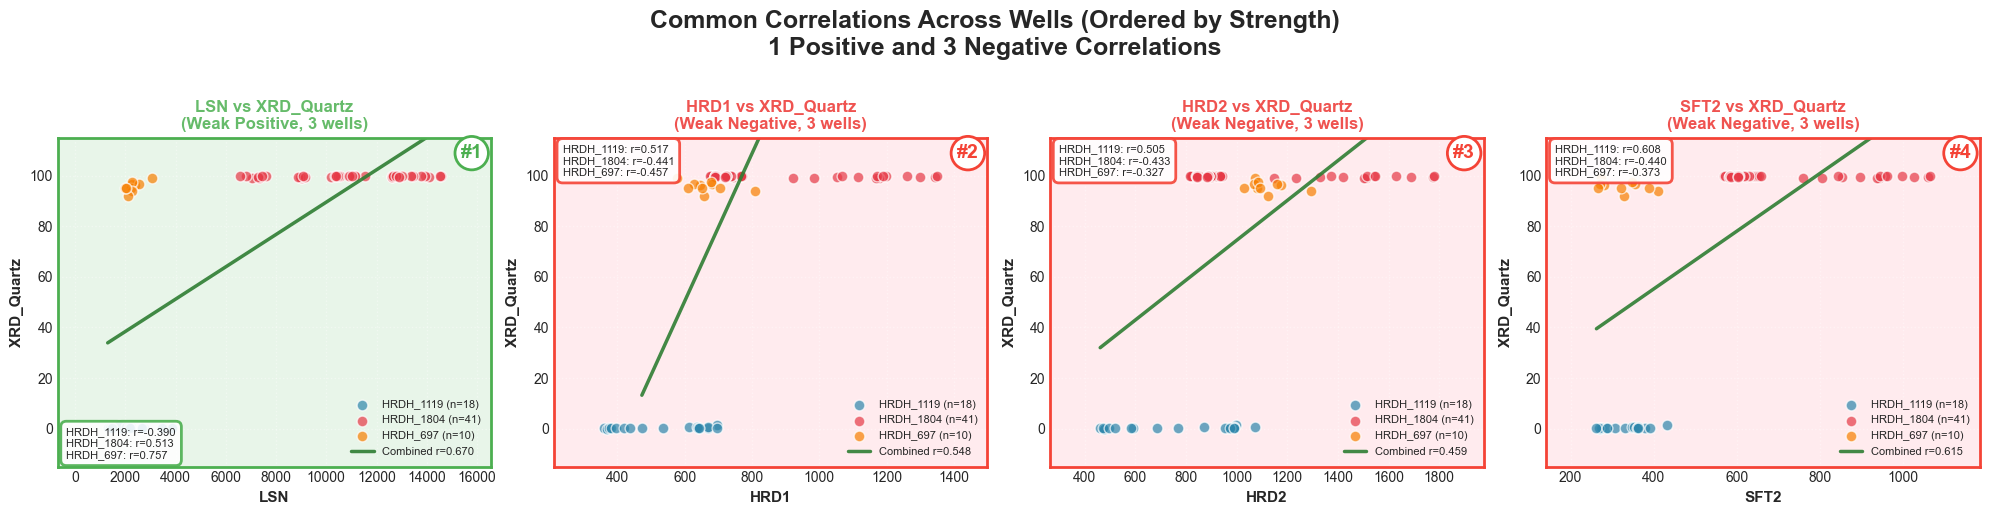


CORRELATION SUMMARY (Ordered by Strength):
Positive correlations: 1
Negative correlations: 3

Top 5 strongest correlations:
1. LSN vs XRD_Quartz: avg r = 0.294 (3 wells)
2. HRD1 vs XRD_Quartz: avg r = -0.127 (3 wells)
3. HRD2 vs XRD_Quartz: avg r = -0.085 (3 wells)
4. SFT2 vs XRD_Quartz: avg r = -0.068 (3 wells)


In [10]:

# If you found correlations in 3+ wells, plot them
if len(common_correlations_3wells) > 0:
    print("\nCreating scatter plots for correlations in 3+ wells:")
    create_combined_scatter_plots(df_all, common_correlations_3wells, n_plots=12)
elif len(common_correlations_all) > 0:
    print("\nCreating scatter plots for correlations in all 4 wells:")
    create_combined_scatter_plots(df_all, common_correlations_all, n_plots=12)



Creating 15 aggregated scatter plots...
Each plot combines data from all wells into a single correlation analysis.

 1. SHR vs XRF_Sr: r = 0.743 (n=28 from 2 wells)
 2. PE vs XRF_Sr: r = -0.771 (n=28 from 2 wells)
 3. LSN vs XRF_Cl: r = -0.239 (n=28 from 2 wells)
 4. PE vs XRF_Fe: r = 0.461 (n=28 from 2 wells)
 5. LSN vs XRD_Quartz: r = 0.801 (n=51 from 2 wells)
 6. SFT2 vs XRF_Si: r = 0.006 (n=28 from 2 wells)
 7. CN vs XRD_Quartz: r = -0.863 (n=51 from 2 wells)
 8. CNC vs XRD_Quartz: r = -0.842 (n=51 from 2 wells)
 9. KTH vs XRF_Na: r = -0.167 (n=28 from 2 wells)
10. SFT2 vs XRF_K: r = 0.208 (n=28 from 2 wells)
11. SFT2 vs XRF_Al: r = 0.248 (n=28 from 2 wells)
12. HRD1 vs XRF_Al: r = 0.604 (n=28 from 2 wells)
13. SFT2 vs XRF_Fe: r = 0.449 (n=28 from 2 wells)
14. HRD1 vs XRF_Si: r = 0.498 (n=28 from 2 wells)
15. SFT2 vs XRF_Sr: r = -0.269 (n=28 from 2 wells)
 1. SHR vs XRF_Sr: r = 0.743 (n=28 from 2 wells)
 2. PE vs XRF_Sr: r = -0.771 (n=28 from 2 wells)
 3. LSN vs XRF_Cl: r = -0.239 

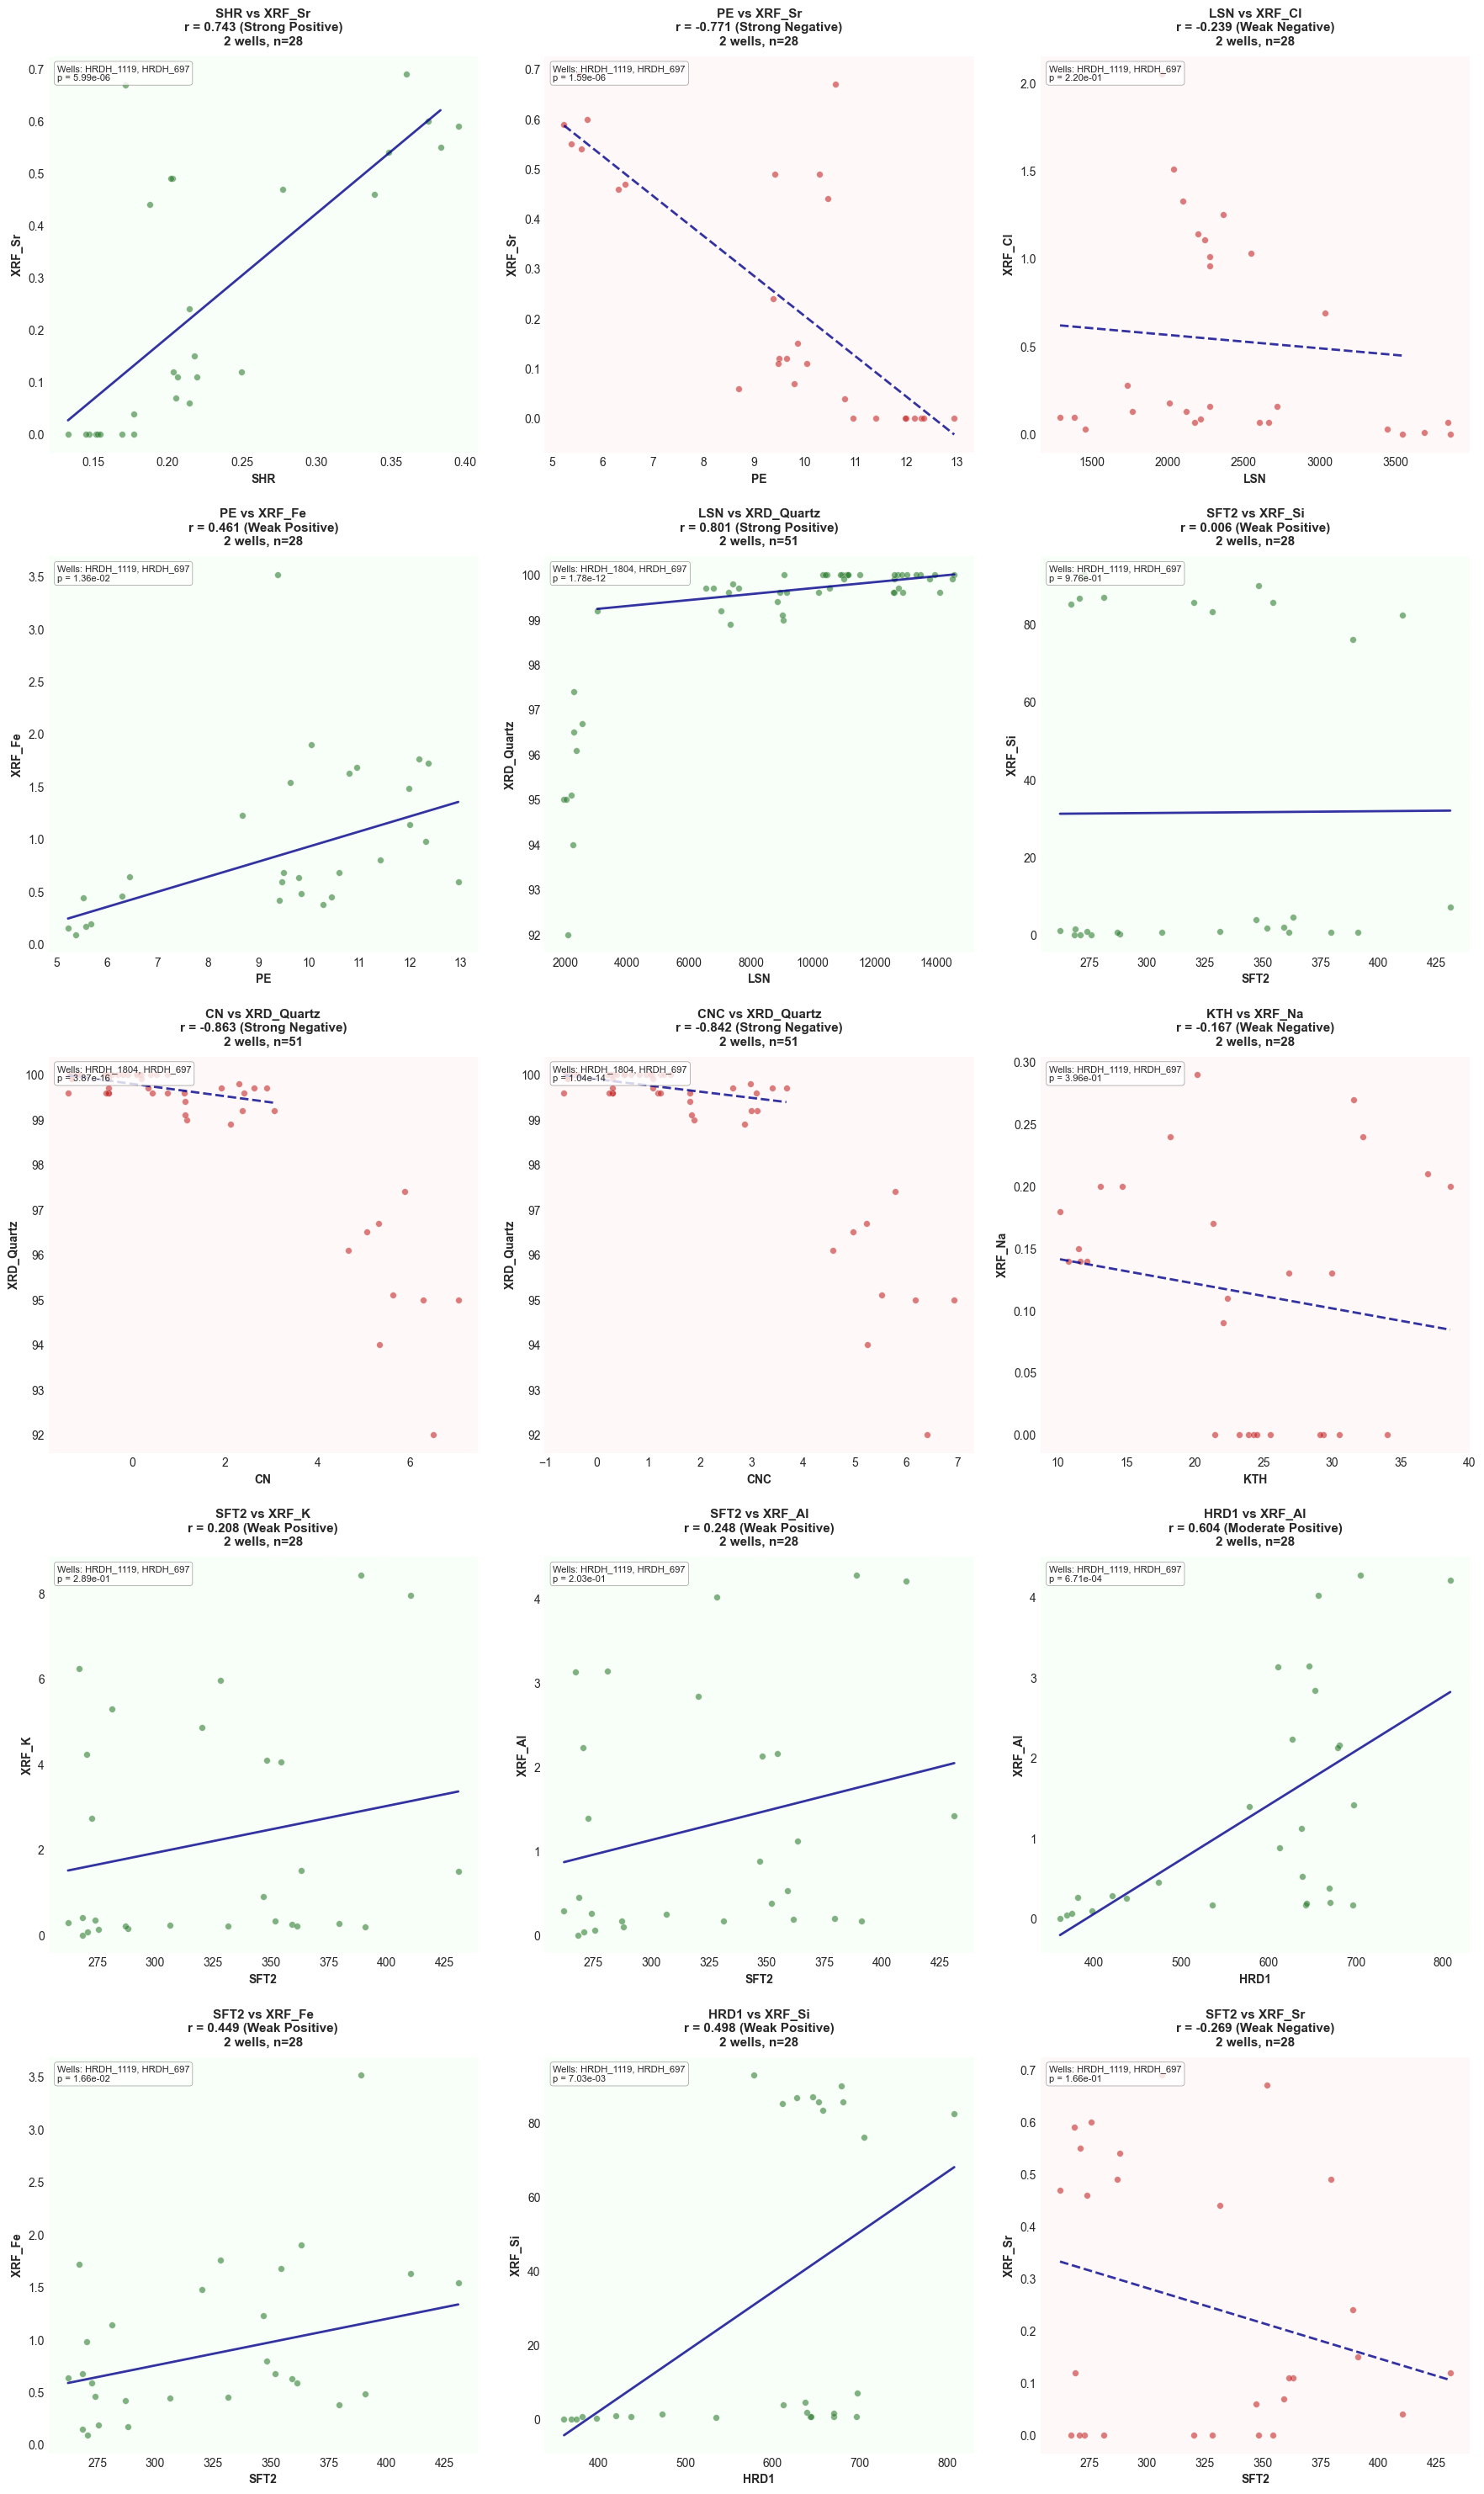


✅ Created combined aggregated scatter plot in 'imgs/aggregated_plots'

Saving individual plots...
✅ Saved 15 individual plots in 'imgs/aggregated_plots'


In [11]:
def create_aggregated_scatter_plots(df, common_correlations, output_dir='imgs/aggregated_plots', n_plots=None):
    """
    Create individual scatter plots where each plot aggregates data from ALL wells 
    for a single correlation pair. Each plot treats all wells as one combined dataset.
    Also saves each subplot individually.
    """
    import os
    from pathlib import Path
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Determine number of plots to create
    pairs_to_plot = common_correlations[:n_plots] if n_plots else common_correlations
    
    print(f"Creating {len(pairs_to_plot)} aggregated scatter plots...")
    print("Each plot combines data from all wells into a single correlation analysis.\n")
    
    # Calculate subplot dimensions
    n_pairs = len(pairs_to_plot)
    cols = 3  # 3 plots per row for better readability
    rows = (n_pairs + cols - 1) // cols  # Ceiling division
    
    # Create the main figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    
    # Handle case where we have only one subplot
    if n_pairs == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Store individual plots data for saving separately
    individual_plots = []
    
    for idx, (pair, wells_data) in enumerate(pairs_to_plot):
        ax = axes_flat[idx]
        log_var, lab_var = pair
        
        # Get list of wells that have this correlation
        wells_with_correlation = [well for well, _ in wells_data]
        
        # AGGREGATE: Combine all data from all wells into one dataset
        wells_data_df = df[df['Well'].isin(wells_with_correlation)]
        aggregated_data = wells_data_df[[log_var, lab_var]].dropna()
        
        if len(aggregated_data) < 10:
            ax.text(0.5, 0.5, f"Insufficient data\n({len(aggregated_data)} points)", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{log_var.replace("Log_", "")} vs {lab_var.replace("Lab_", "")}', 
                        fontsize=12, fontweight='bold')
            continue
        
        # Calculate aggregated correlation
        overall_r, overall_p = stats.pearsonr(aggregated_data[log_var], aggregated_data[lab_var])
        
        # Plot ALL points as one aggregated dataset
        x_data = aggregated_data[log_var].values
        y_data = aggregated_data[lab_var].values
        
        # Choose color based on correlation direction
        point_color = '#2E7D32' if overall_r > 0 else '#C62828'  # Green for positive, red for negative
        
        scatter = ax.scatter(x_data, y_data, 
                  alpha=0.6, s=30, 
                  color=point_color,
                  edgecolors='white', linewidth=0.3)
        
        # Add regression line
        # Remove outliers for better line fitting
        q1_x, q3_x = np.percentile(x_data, [25, 75])
        q1_y, q3_y = np.percentile(y_data, [25, 75])
        iqr_x = q3_x - q1_x
        iqr_y = q3_y - q1_y
        
        mask = ((x_data >= q1_x - 1.5*iqr_x) & (x_data <= q3_x + 1.5*iqr_x) & 
                (y_data >= q1_y - 1.5*iqr_y) & (y_data <= q3_y + 1.5*iqr_y))
        
        x_clean = x_data[mask]
        y_clean = y_data[mask]
        
        regression_line = None
        if len(x_clean) > 10:
            z = np.polyfit(x_clean, y_clean, 1)
            p = np.poly1d(z)
            x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
            
            line_style = '-' if overall_r > 0 else '--'
            regression_line = ax.plot(x_line, p(x_line), 
                   color='darkblue', linestyle=line_style, 
                   linewidth=2, alpha=0.8)
        
        # Customize subplot
        ax.set_xlabel(log_var.replace('Log_', ''), fontsize=10, fontweight='bold')
        ax.set_ylabel(lab_var.replace('Lab_', ''), fontsize=10, fontweight='bold')
        
        # Determine correlation strength
        if abs(overall_r) >= 0.7:
            strength = "Strong"
        elif abs(overall_r) >= 0.5:
            strength = "Moderate"
        else:
            strength = "Weak"
        
        correlation_type = "Positive" if overall_r > 0 else "Negative"
        
        # Create title
        title = f'{log_var.replace("Log_", "")} vs {lab_var.replace("Lab_", "")}\n'
        title += f'r = {overall_r:.3f} ({strength} {correlation_type})\n'
        title += f'{len(wells_with_correlation)} wells, n={len(aggregated_data)}'
        
        ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
        
        # Set background color
        if overall_r > 0:
            ax.set_facecolor('#F8FFF8')  # Very light green
        else:
            ax.set_facecolor('#FFF8F8')  # Very light red
        
        # Add stats text box (smaller for subplot)
        stats_text = f"Wells: {', '.join(wells_with_correlation[:2])}"
        if len(wells_with_correlation) > 2:
            stats_text += f"\n+ {len(wells_with_correlation)-2} more"
        stats_text += f"\np = {overall_p:.2e}"
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle='round,pad=0.3', 
                        facecolor='white', 
                        edgecolor='gray',
                        alpha=0.8,
                        linewidth=0.5))
        
        # Store data for individual plot
        individual_plots.append({
            'idx': idx,
            'log_var': log_var,
            'lab_var': lab_var,
            'x_data': x_data,
            'y_data': y_data,
            'overall_r': overall_r,
            'overall_p': overall_p,
            'wells_with_correlation': wells_with_correlation,
            'title': title,
            'strength': strength,
            'correlation_type': correlation_type,
            'point_color': point_color,
            'regression_params': (z, p, x_line) if len(x_clean) > 10 else None,
            'wells_data': wells_data
        })
        
        # Print progress
        print(f"{idx+1:2d}. {log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}: "
              f"r = {overall_r:.3f} (n={len(aggregated_data)} from {len(wells_with_correlation)} wells)")
    
    # Hide empty subplots
    for idx in range(len(pairs_to_plot), len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    # Adjust layout and save combined plot
    plt.tight_layout(pad=2.0)
    
    # Save the combined plot
    filename = f"aggregated_correlations_combined.png"
    filepath = Path(output_dir) / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\n✅ Created combined aggregated scatter plot in '{output_dir}'")
    
    # Now save individual plots
    print("\nSaving individual plots...")
    
    # Define well colors for consistency
    well_colors_dict = {
        'HRDH_1119': '#2E86AB',
        'HRDH_1804': '#E63946',
        'HRDH_1867': '#06D6A0',
        'HRDH_697': '#F77F00'
    }
    
    for plot_data in individual_plots:
        # Create a new figure for individual plot
        fig_individual, ax_individual = plt.subplots(figsize=(10, 8))
        
        # Recreate the scatter plot
        ax_individual.scatter(plot_data['x_data'], plot_data['y_data'], 
                             alpha=0.6, s=50, 
                             color=plot_data['point_color'],
                             edgecolors='white', linewidth=0.5,
                             label=f'Aggregated Data (n={len(plot_data["x_data"])})')
        
        # Add regression line if available
        if plot_data['regression_params'] is not None:
            z, p, x_line = plot_data['regression_params']
            line_style = '-' if plot_data['overall_r'] > 0 else '--'
            ax_individual.plot(x_line, p(x_line), 
                              color='darkblue', linestyle=line_style, 
                              linewidth=2.5, alpha=0.8,
                              label=f'Regression Line (r={plot_data["overall_r"]:.3f})')
        
        # Create custom legend with well correlations
        # Get current legend handles and labels
        handles, labels = ax_individual.get_legend_handles_labels()
        
        # Add a separator
        handles.append(plt.Line2D([0], [0], color='none'))
        labels.append('')
        
        # Add header for individual well correlations
        handles.append(plt.Line2D([0], [0], color='none'))
        labels.append('Individual Well Correlations:')
        
        # Add each well's correlation with proper formatting and color
        for well, r in plot_data['wells_data']:
            # Create a colored marker for each well
            well_color = well_colors_dict.get(well, 'gray')
            handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=well_color, markersize=8))
            labels.append(f'{well}: r = {r:.3f}')
        
        # Create the legend with all items
        ax_individual.legend(handles, labels, loc='best', fontsize=10, 
                            framealpha=0.9, edgecolor='gray', frameon=True)
        
        # Customize individual plot
        ax_individual.set_xlabel(plot_data['log_var'].replace('Log_', ''), fontsize=14, fontweight='bold')
        ax_individual.set_ylabel(plot_data['lab_var'].replace('Lab_', ''), fontsize=14, fontweight='bold')
        ax_individual.set_title(plot_data['title'], fontsize=14, fontweight='bold', pad=15)
        
        # Add grid
        ax_individual.grid(True, alpha=0.3, linestyle=':', linewidth=1)
        
        # Set background color
        if plot_data['overall_r'] > 0:
            ax_individual.set_facecolor('#F8FFF8')  # Very light green
        else:
            ax_individual.set_facecolor('#FFF8F8')  # Very light red
        
        # Add comprehensive stats text box
        stats_text = f"Statistics:\n"
        stats_text += f"Correlation: r = {plot_data['overall_r']:.3f}\n"
        stats_text += f"P-value: {plot_data['overall_p']:.2e}\n"
        stats_text += f"Sample Size: {len(plot_data['x_data'])}\n"
        stats_text += f"Wells: {', '.join(plot_data['wells_with_correlation'])}"
        
        ax_individual.text(0.02, 0.98, stats_text, transform=ax_individual.transAxes,
                          fontsize=10, verticalalignment='top', horizontalalignment='left',
                          bbox=dict(boxstyle='round,pad=0.5', 
                                   facecolor='white', 
                                   edgecolor='gray',
                                   alpha=0.9,
                                   linewidth=1))
        
        # Save individual plot
        individual_filename = f"aggregated_{plot_data['idx']+1:02d}_{plot_data['log_var'].replace('Log_', '')}_{plot_data['lab_var'].replace('Lab_', '')}.png"
        individual_filepath = Path(output_dir) / individual_filename
        
        plt.tight_layout()
        fig_individual.savefig(individual_filepath, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig_individual)
    
    print(f"✅ Saved {len(individual_plots)} individual plots in '{output_dir}'")


# Usage:
create_aggregated_scatter_plots(df_all, common_correlations, n_plots=15)

In [12]:
# Add this function to check for outliers in specific variable pairs
def check_data_distribution(df, log_var, lab_var):
    """Check data distribution and identify potential outliers"""
    
    data = df[[log_var, lab_var, 'Well']].dropna()
    
    print(f"\nData distribution for {log_var} vs {lab_var}:")
    print(f"Total samples: {len(data)}")
    
    # Basic statistics
    print(f"\n{log_var} statistics:")
    print(data[log_var].describe())
    
    print(f"\n{lab_var} statistics:")
    print(data[lab_var].describe())
    
    # Check for potential outliers
    for var in [log_var, lab_var]:
        q1, q3 = data[var].quantile([0.25, 0.75])
        iqr = q3 - q1
        outliers = data[(data[var] < q1 - 1.5*iqr) | (data[var] > q3 + 1.5*iqr)]
        
        if len(outliers) > 0:
            print(f"\nPotential outliers in {var}: {len(outliers)} samples")
            print(f"Outlier range: [{outliers[var].min():.2f}, {outliers[var].max():.2f}]")
            print(f"Normal range: [{q1 - 1.5*iqr:.2f}, {q3 + 1.5*iqr:.2f}]")

# Example usage - check the first correlation pair
if len(common_correlations) > 0:
    pair = common_correlations[0][0]
    check_data_distribution(df_all, pair[0], pair[1])


Data distribution for Log_SHR vs Lab_XRF_Sr:
Total samples: 28

Log_SHR statistics:
count    28.000000
mean      0.227968
std       0.080936
min       0.133060
25%       0.170985
50%       0.204501
75%       0.256579
max       0.395234
Name: Log_SHR, dtype: float64

Lab_XRF_Sr statistics:
count    28.000000
mean      0.250357
std       0.252520
min       0.000000
25%       0.000000
50%       0.120000
75%       0.490000
max       0.690000
Name: Lab_XRF_Sr, dtype: float64

Potential outliers in Log_SHR: 1 samples
Outlier range: [0.40, 0.40]
Normal range: [0.04, 0.38]


# Correlation Consistency Analysis


In [13]:
def analyze_correlation_consistency(common_correlations, well_correlations):
    """Analyze how consistent correlations are across wells"""
    
    consistency_data = []
    
    for pair, wells_data in common_correlations[:20]:  # Top 20 pairs
        log_var, lab_var = pair
        
        # Get correlations from all wells
        all_well_corrs = []
        for well, corr_matrix in well_correlations.items():
            r = corr_matrix.loc[log_var, lab_var]
            if not pd.isna(r):
                all_well_corrs.append(r)
        
        if len(all_well_corrs) >= 2:
            consistency_data.append({
                'Variable_Pair': f'{log_var.replace("Log_", "")} vs {lab_var.replace("Lab_", "")}',
                'Mean_r': np.mean(all_well_corrs),
                'Std_r': np.std(all_well_corrs),
                'Min_r': np.min(all_well_corrs),
                'Max_r': np.max(all_well_corrs),
                'Range_r': np.max(all_well_corrs) - np.min(all_well_corrs),
                'N_Wells': len(all_well_corrs)
            })
    
    consistency_df = pd.DataFrame(consistency_data)
    consistency_df = consistency_df.sort_values('Std_r')
    
    return consistency_df

# Analyze consistency
consistency_df = analyze_correlation_consistency(common_correlations, well_correlations)

print("Correlation Consistency Analysis (Top 10 most consistent):")
print(consistency_df.head(10).to_string(index=False, float_format='%.3f'))

Correlation Consistency Analysis (Top 10 most consistent):
    Variable_Pair  Mean_r  Std_r  Min_r  Max_r  Range_r  N_Wells
   SFT2 vs XRF_Fe   0.568  0.011  0.557  0.580    0.023        2
   SFT2 vs XRF_Al   0.582  0.023  0.559  0.605    0.046        2
    SFT2 vs XRF_K   0.584  0.024  0.560  0.608    0.049        2
    KTH vs XRF_Na   0.608  0.057  0.551  0.665    0.113        2
   HRD1 vs XRF_Al   0.574  0.060  0.514  0.634    0.119        2
    LSN vs XRF_Cl  -0.663  0.108 -0.772 -0.555    0.217        2
     PE vs XRF_Sr  -0.689  0.129 -0.818 -0.560    0.258        2
    SHR vs XRF_Sr   0.691  0.139  0.552  0.830    0.278        2
 CN vs XRD_Quartz  -0.332  0.410 -0.707  0.238    0.945        3
CNC vs XRD_Quartz  -0.325  0.411 -0.707  0.245    0.952        3


# Visualize correlation consistency


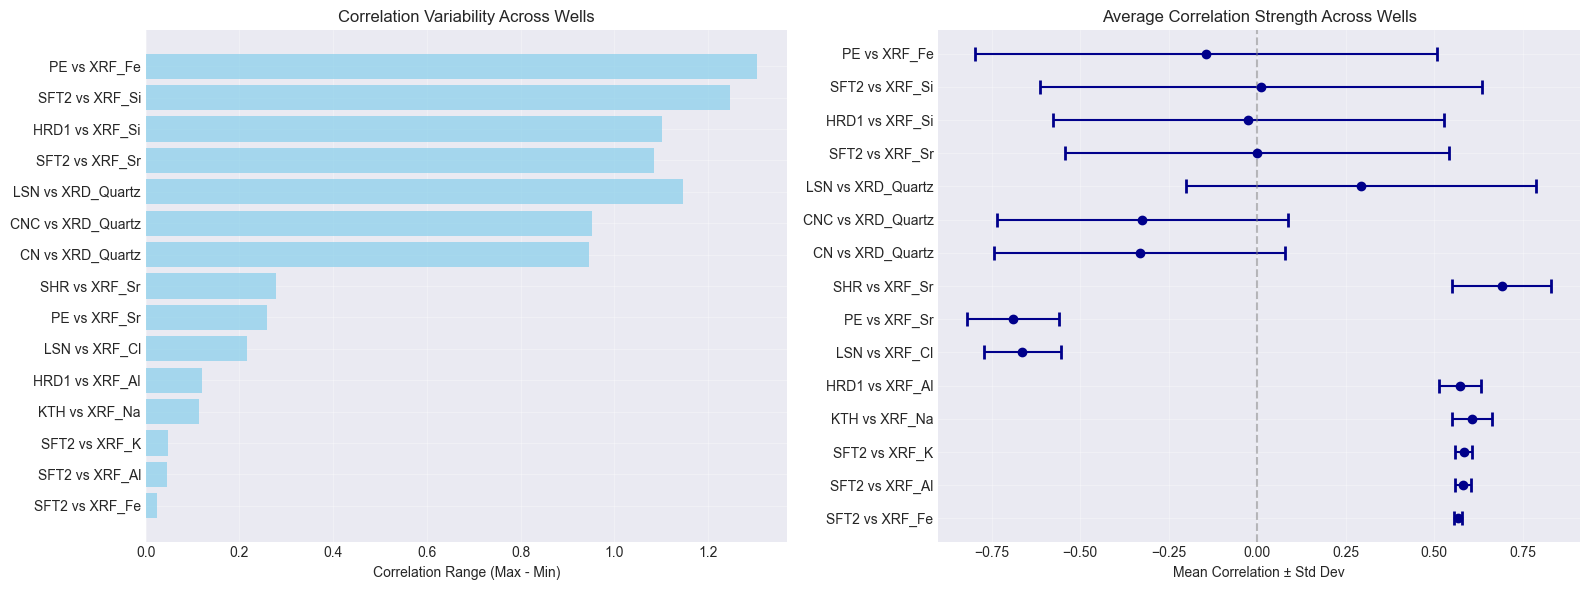

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Correlation ranges
y_pos = np.arange(len(consistency_df.head(15)))
ax1.barh(y_pos, consistency_df.head(15)['Range_r'], alpha=0.7, color='skyblue')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(consistency_df.head(15)['Variable_Pair'])
ax1.set_xlabel('Correlation Range (Max - Min)')
ax1.set_title('Correlation Variability Across Wells')
ax1.grid(True, alpha=0.3)

# Plot 2: Mean correlation with error bars
ax2.errorbar(consistency_df.head(15)['Mean_r'], y_pos, 
             xerr=consistency_df.head(15)['Std_r'],
             fmt='o', capsize=5, capthick=2, color='darkblue')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(consistency_df.head(15)['Variable_Pair'])
ax2.set_xlabel('Mean Correlation ± Std Dev')
ax2.set_title('Average Correlation Strength Across Wells')
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('imgs/correlation_consistency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Summary Statistics and Export


In [15]:
# Create summary report
print("=" * 80)
print("COMBINED WELL ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nDataset Overview:")
print(f"  - Total samples: {len(df_all):,}")
print(f"  - Number of wells: {df_all['Well'].nunique()}")
print(f"  - Lab variables: {len(lab_columns)}")
print(f"  - Log variables: {len(log_columns)}")

print(f"\nData Quality:")
print(f"  - Overall completeness: {(1 - df_all.isnull().sum().sum() / (len(df_all) * len(df_all.columns))) * 100:.1f}%")
print(f"  - Columns with >50% missing: {len(high_missing)}")

print(f"\nCorrelation Analysis:")
print(f"  - Variable pairs with |r| ≥ 0.5 in ≥2 wells: {len(common_correlations)}")
print(f"  - Most consistent correlation: {consistency_df.iloc[0]['Variable_Pair']} (σ = {consistency_df.iloc[0]['Std_r']:.3f})")
print(f"  - Strongest average correlation: {consistency_df.loc[consistency_df['Mean_r'].abs().idxmax(), 'Variable_Pair']} (r̄ = {consistency_df.loc[consistency_df['Mean_r'].abs().idxmax(), 'Mean_r']:.3f})")

COMBINED WELL ANALYSIS SUMMARY

Dataset Overview:
  - Total samples: 78
  - Number of wells: 4
  - Lab variables: 35
  - Log variables: 15

Data Quality:
  - Overall completeness: 68.3%
  - Columns with >50% missing: 33

Correlation Analysis:
  - Variable pairs with |r| ≥ 0.5 in ≥2 wells: 15
  - Most consistent correlation: SFT2 vs XRF_Fe (σ = 0.011)
  - Strongest average correlation: SHR vs XRF_Sr (r̄ = 0.691)


In [16]:
# Export results
# Save common correlations
common_corr_df = []
for pair, wells_data in common_correlations:
    log_var, lab_var = pair
    for well, r in wells_data:
        common_corr_df.append({
            'Log_Variable': log_var,
            'Lab_Variable': lab_var,
            'Well': well,
            'Correlation': r
        })

common_corr_df = pd.DataFrame(common_corr_df)
common_corr_df.to_csv('imgs/common_correlations_all_wells.csv', index=False)

# Save consistency analysis
consistency_df.to_csv('imgs/correlation_consistency_analysis.csv', index=False)

print("\n✅ Results exported to:")
print("  - imgs/common_correlations_all_wells.csv")
print("  - imgs/correlation_consistency_analysis.csv")


✅ Results exported to:
  - imgs/common_correlations_all_wells.csv
  - imgs/correlation_consistency_analysis.csv


#  Interactive Exploration Tool 


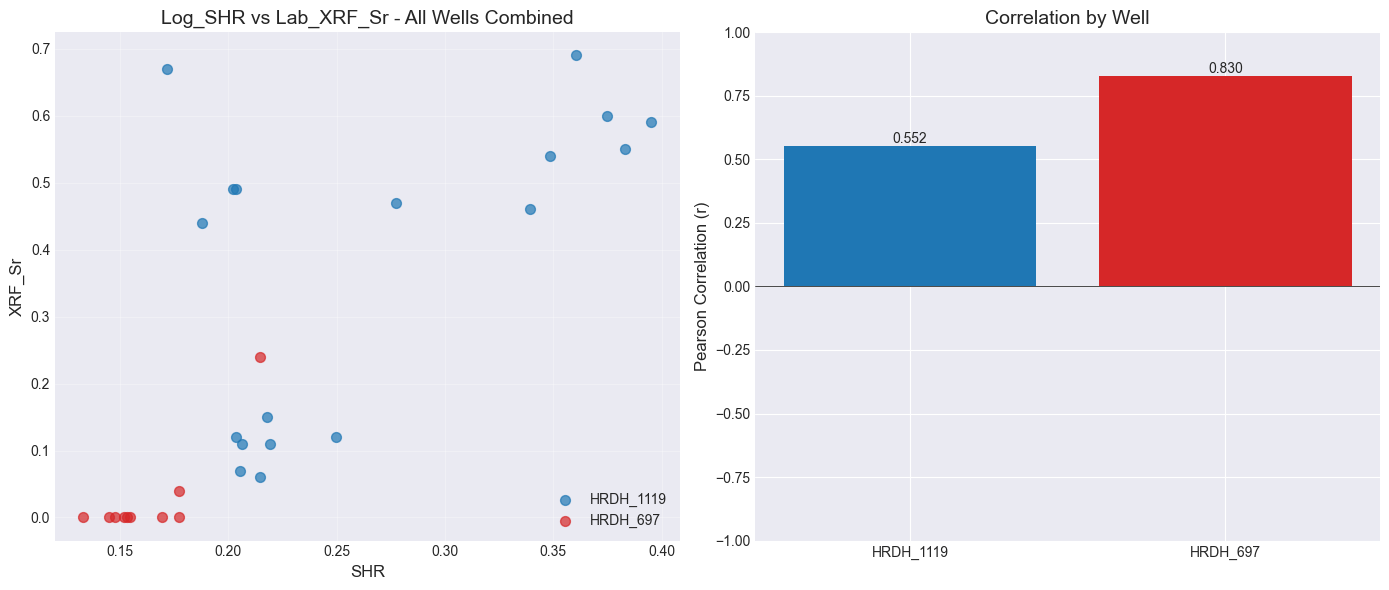

In [17]:
def plot_specific_correlation(df, log_var, lab_var):
    """Create detailed plot for a specific variable pair"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: Combined scatter
    ax1 = axes[0]
    for well in df['Well'].unique():
        well_data = df[df['Well'] == well]
        plot_data = well_data[[log_var, lab_var]].dropna()
        
        if len(plot_data) > 0:
            ax1.scatter(plot_data[log_var], plot_data[lab_var], 
                       label=well, alpha=0.7, s=50,
                       color=well_colors.get(well, 'gray'))
    
    ax1.set_xlabel(log_var.replace('Log_', ''), fontsize=12)
    ax1.set_ylabel(lab_var.replace('Lab_', ''), fontsize=12)
    ax1.set_title(f'{log_var} vs {lab_var} - All Wells Combined', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Correlation by well
    ax2 = axes[1]
    well_names = []
    correlations = []
    
    for well in df['Well'].unique():
        well_data = df[df['Well'] == well]
        clean_data = well_data[[log_var, lab_var]].dropna()
        
        if len(clean_data) >= 10:
            r, p = stats.pearsonr(clean_data[log_var], clean_data[lab_var])
            well_names.append(well)
            correlations.append(r)
    
    bars = ax2.bar(well_names, correlations, color=[well_colors.get(w, 'gray') for w in well_names])
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_ylabel('Pearson Correlation (r)', fontsize=12)
    ax2.set_title('Correlation by Well', fontsize=14)
    ax2.set_ylim(-1, 1)
    
    # Add value labels on bars
    for bar, corr in zip(bars, correlations):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{corr:.3f}', ha='center', va='bottom' if height > 0 else 'top')
    
    plt.tight_layout()
    plt.show()

# Example usage - plot a specific correlation
if len(common_correlations) > 0:
    # Plot the strongest common correlation
    example_pair = common_correlations[0][0]
    plot_specific_correlation(df_all, example_pair[0], example_pair[1])